This notebook is used to train pure DNN in US-Hn1 site.

# Load the necessary libraries

In [1]:
# # TODO: A more generic way is needed here to load the path
# import sys

# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
#     # "/global/homes/p/peishi89/jax-watershed/src"
# )

In [2]:
import time

from typing import List

import optax
import equinox as eqx

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn import preprocessing

import numpy as np
import jax
import jax.numpy as jnp

from jax_canveg.subjects import get_met_forcings, get_obs
from jax_canveg.shared_utilities.plot import get_time
from jax_canveg.shared_utilities import compute_metrics

import matplotlib.pyplot as plt
from jax_canveg.shared_utilities.plot import (
    plot_timeseries_obs_1to1,
)

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_debug_infs", False)

%load_ext autoreload
%autoreload 2

In [3]:
small_size = 15
medium_size = 25
bigger_size = 30
plt.rc("font", size=small_size)  # controls default text sizes
plt.rc("axes", titlesize=small_size)  # fontsize of the axes title
plt.rc("axes", labelsize=small_size)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
plt.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
plt.rc("legend", fontsize=small_size)  # legend fontsize
plt.rc("figure", titlesize=small_size)  # fontsize of the figure title
plt.rc("text", usetex=False)

# Files / directories / DL hyperparameters

In [4]:
site, key = "US-Hn1", "dl"

# Calibration period
f_forcing = f"../../data/fluxtower/{site}/{site}-forcings-v2.csv"
f_obs = f"../../data/fluxtower/{site}/{site}-fluxes-nonegle-v2.csv"

# Test period
f_forcing_test = f"../../data/fluxtower/{site}/{site}-forcings-test-v2.csv"
f_obs_test = f"../../data/fluxtower/{site}/{site}-fluxes-nonegle-test-v2.csv"

# Models
f_model = f"{site}_{key}_model.eqx"

In [5]:
# Hyperparameters
batch_size = 64
initial_lr = 2e-1
# initial_lr = 2e-2
nsteps = 300
seed = 5678

key = jax.random.PRNGKey(seed)

# Load forcings and outputs

In [6]:
varns = [
    "T_air",
    "rglobal",
    "eair",
    "wind",
    "CO2",
    "P_kPa",
    "ustar",
    "soilmoisture",
    "lai",
]

In [7]:
# Calibration period
met, n_time = get_met_forcings(f_forcing)
timesteps = get_time(met)
obs = get_obs(f_obs)
x = np.array(
    [
        met.T_air,
        met.rglobal,
        met.eair,
        met.wind,
        met.CO2,
        met.P_kPa,
        met.ustar,
        met.soilmoisture,
        met.lai,
    ]
).T
y = obs.LE
y = np.expand_dims(y, axis=-1)

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


In [8]:
# Test period
met_test, n_time_test = get_met_forcings(f_forcing_test)
timesteps_test = get_time(met_test)
obs_test = get_obs(f_obs_test)
x_test = np.array(
    [
        met_test.T_air,
        met_test.rglobal,
        met_test.eair,
        met_test.wind,
        met_test.CO2,
        met_test.P_kPa,
        met_test.ustar,
        met_test.soilmoisture,
        met_test.lai,
    ]
).T
y_test = obs_test.LE
y_test = np.expand_dims(y_test, axis=-1)

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


# Normalize the data

In [9]:
scaler_x = preprocessing.StandardScaler().fit(x)
scaler_y = preprocessing.StandardScaler().fit(y)

In [10]:
x_norm = scaler_x.transform(x)
y_norm = scaler_y.transform(y)
x_test_norm = scaler_x.transform(x_test)
y_test_norm = scaler_y.transform(y_test)

In [11]:
# x_norm = jax.nn.standardize(x,axis=0)
# y_norm = jax.nn.standardize(y,axis=0)
# x_test_norm = jax.nn.standardize(x_test,axis=0)
# y_test_norm = jax.nn.standardize(y_test,axis=0)

# MLP

## Create dataset and dataloader

In [12]:
# Ensure reproducibility
torch.manual_seed(14026282050284255032)

In [13]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        # Return the size of the dataset, which is the length of one of the arrays
        return len(self.x)

    def __getitem__(self, idx):
        # Retrieve and return the corresponding elements from both arrays
        sample1 = self.x[idx]
        sample2 = self.y[idx]
        return sample1, sample2

In [14]:
# train_dataset = CustomDataset(x_norm, y_norm)
# test_dataset = CustomDataset(x_test_norm, y_test_norm)
train_dataset = CustomDataset(np.array(x_norm), np.array(y_norm))
test_dataset = CustomDataset(np.array(x_test_norm), np.array(y_test_norm))
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

## Train a MLP model

In [15]:
# Define a deep learning model
n_input, n_output = x.shape[1], y.shape[1]
n_depth, n_node = 6, 6

model = eqx.nn.MLP(
    n_input,
    n_output,
    n_depth,
    n_node,
    # activation=jax.nn.tanh, key=key
    activation=jax.nn.leaky_relu,
    key=key,
)

In [16]:
# Training setup
scheduler = optax.piecewise_constant_schedule(
    initial_lr, boundaries_and_scales={50: 0.1, 100: 0.1, 200: 0.1}
)
# scheduler = optax.piecewise_constant_schedule(
#     initial_lr, boundaries_and_scales={50: 0.5, 100: 0.5, 200: 0.5}
# )
# scheduler = optax.constant_schedule(initial_lr)
optim = optax.adam(learning_rate=scheduler)  # Adam optimizer

In [17]:
# Loss function
@eqx.filter_jit
def loss_func(model, x_batch, y_batch):
    pred_y_batch = jax.vmap(model)(x_batch)
    return jnp.mean((y_batch - pred_y_batch) ** 2)

In [18]:
opt_state = optim.init(eqx.filter(model, eqx.is_array))


@eqx.filter_jit
def make_step(model, opt_state, x_batch, y_batch):
    loss_value, grads = eqx.filter_value_and_grad(loss_func)(model, x_batch, y_batch)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


loss_train_all = []
loss_test_all = []
for step in range(nsteps):
    # for step in range(20):
    start_time = time.time()
    for x_batch_tensor, y_batch_tensor in trainloader:
        x_batch, y_batch = jnp.array(x_batch_tensor), jnp.array(y_batch_tensor)
        model, opt_state, loss_batch = make_step(model, opt_state, x_batch, y_batch)
    epoch_time = time.time() - start_time

    loss_train = loss_func(model, x_norm, y_norm)
    loss_test = loss_func(model, x_test_norm, y_test_norm)

    loss_train_all.append(loss_train)
    loss_test_all.append(loss_test)
    print(
        f"The training loss of step {step}: {loss_train}; the test loss of step {step}: {loss_test}."
    )
    # print("Epoch {} in {:0.2f} sec".format(step, epoch_time))
    # print("Training set loss: {}".format(loss_train))
    # print("Test set loss {}".format(loss_test))

The training loss of step 0: 0.9991117215739898; the test loss of step 0: 0.34955544829757673.
The training loss of step 1: 0.9989126761099969; the test loss of step 1: 0.3504618438510983.
The training loss of step 2: 0.9986963391229358; the test loss of step 2: 0.3511891546737657.
The training loss of step 3: 0.9984317164489778; the test loss of step 3: 0.3515699158289827.
The training loss of step 4: 0.9980410955984955; the test loss of step 4: 0.35183627154130215.
The training loss of step 5: 0.997430382950679; the test loss of step 5: 0.3517353330752634.
The training loss of step 6: 0.9953638081701791; the test loss of step 6: 0.351140914075043.
The training loss of step 7: 0.9489644520212316; the test loss of step 7: 0.35595842338106154.
The training loss of step 8: 0.8650939843697993; the test loss of step 8: 0.43734723329381264.
The training loss of step 9: 0.7812691386346302; the test loss of step 9: 0.5473679493988877.
The training loss of step 10: 0.7030061511070509; the test

[None]

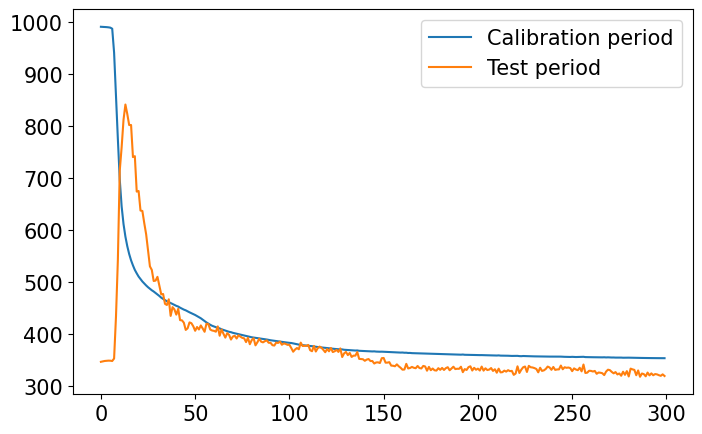

In [19]:
# Plot the loss function
loss_train_all = loss_train_all * scaler_y.var_
loss_test_all = loss_test_all * scaler_y.var_

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(loss_train_all, label="Calibration period")
ax.plot(loss_test_all, label="Test period")
ax.legend()
ax.set(yscale="linear")

# Predictions on both training and test datasets

In [20]:
def l2_func(y, y_true):
    return np.mean((y - y_true) ** 2)

In [21]:
# Sensitivity analysis
def model_scaler(x, model):
    return model(x)[0]

## MLP

### Sensitivity analysis

In [33]:
grad = jax.vmap(jax.grad(model_scaler), in_axes=[0, None])(x_norm, model)
grad_test = jax.vmap(jax.grad(model_scaler), in_axes=[0, None])(x_test_norm, model)

In [53]:
# fig, axes = plt.subplots(len(varns), 1, figsize = (20, 20))
# for i,ax in enumerate(axes):
#     ax.plot(grad[:,i])
#     ax.set(ylabel=varns[i])
# # grad.mean(axis=0), grad_test.mean(axis=0)

In [54]:
# fig, axes = plt.subplots(len(varns), 1, figsize = (20, 20))
# for i,ax in enumerate(axes):
#     ax.plot(grad_test[:,i])
#     ax.set(ylabel=varns[i])
# # grad.mean(axis=0), grad_test.mean(axis=0)

### Predictions

In [22]:
pred_y_norm_calib = jax.vmap(model)(x_norm)
pred_y_norm_test = jax.vmap(model)(x_test_norm)

pred_y_calib = scaler_y.inverse_transform(pred_y_norm_calib)
pred_y_test = scaler_y.inverse_transform(pred_y_norm_test)

l2_calib = l2_func(pred_y_calib, y)
l2_test = l2_func(pred_y_test, y_test)

In [23]:
metrics = compute_metrics(pred_y_calib, y)
metrics_test = compute_metrics(pred_y_test, y_test)
print(metrics)
print(metrics_test)

{'rmse': 18.811809144184554, 'mse': 353.88416327722564, 'r2': 0.4530260681571212, 'kge': 0.7237611122344972, 'nse': 0.6434164049577612, 'mkge': 0.729121975202882, 'cc': 0.802190886608544, 'alpha': 0.990466340218393, 'beta': 0.8151877484893312}
{'rmse': 17.878841263693428, 'mse': 319.6529649323468, 'r2': -0.04540646291557815, 'kge': 0.3311459077118336, 'nse': -0.24396760641097393, 'mkge': 0.28278815245735434, 'cc': 0.5689580210529123, 'alpha': 1.503305371663643, 'beta': 0.7256291752109278}


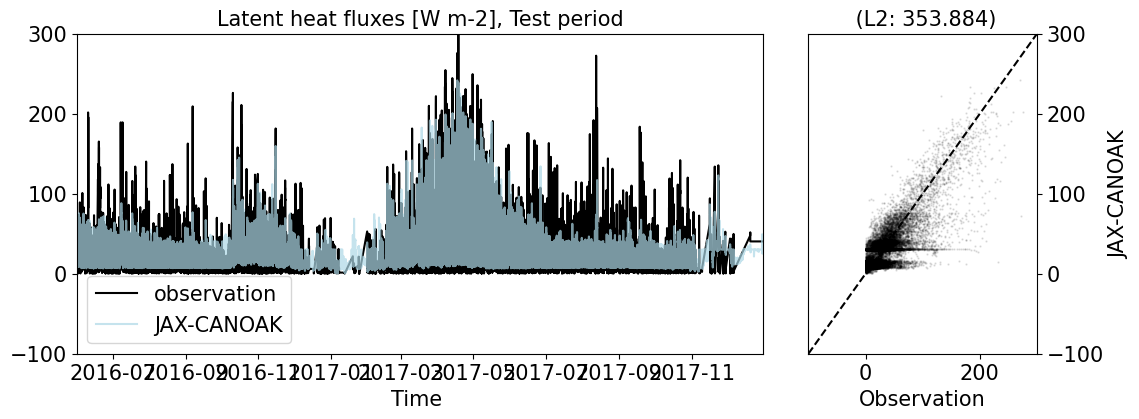

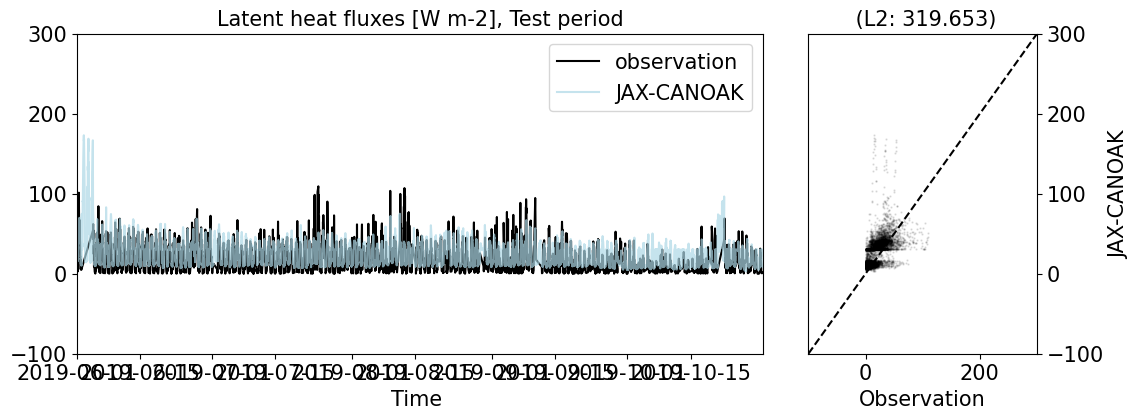

In [26]:
plot_timeseries_obs_1to1(
    y,
    pred_y_calib,
    lim=[-100, 300],
    met=met,
    varn="Latent heat fluxes [W m-2], Test period",
)

plot_timeseries_obs_1to1(
    y_test,
    pred_y_test,
    lim=[-100, 300],
    met=met_test,
    varn="Latent heat fluxes [W m-2], Test period",
);

In [25]:
# fig, axes = plt.subplots(2, 1, figsize=(12, 8))
# ax = axes[0]
# ax.plot(timesteps, y, label="obs")
# ax.plot(timesteps, pred_y_calib, label="DNN")
# ax.set(
#     title=f"Calibration period (L2: {l2_calib})", ylabel="Latent heat fluxes [W m-2]"
# )
# ax.legend()

# ax = axes[1]
# ax.plot(timesteps_test, y_test, label="obs")
# ax.plot(timesteps_test, pred_y_test, label="DNN")
# ax.set(title=f"Test period (L2: {l2_test})", ylabel="Latent heat fluxes [W m-2]")
# ax.legend()

## Plot

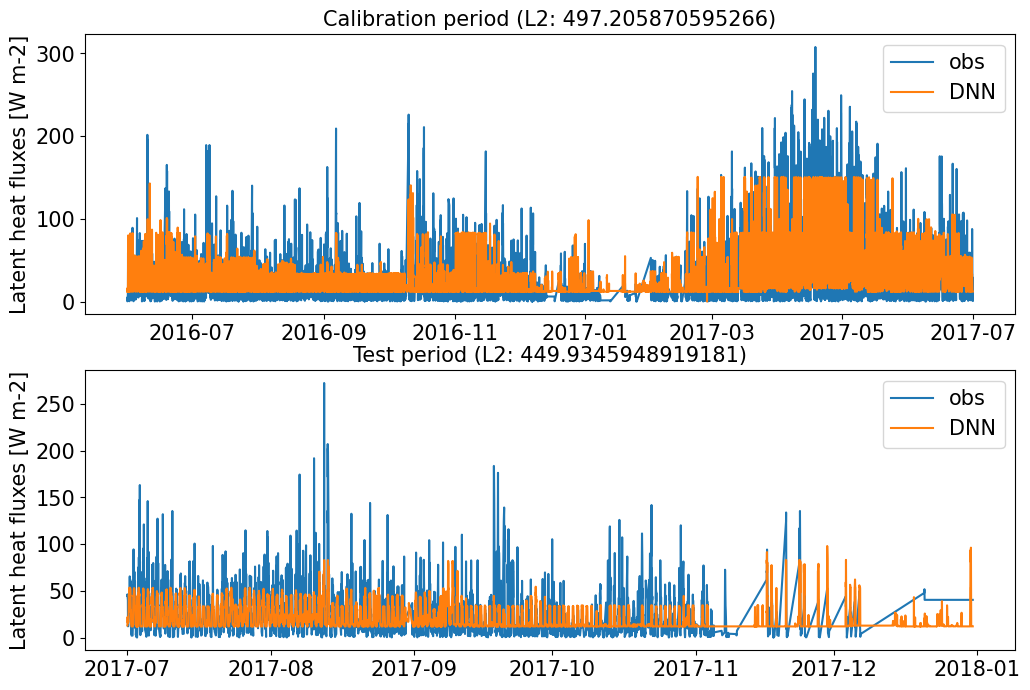

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
ax = axes[0]
ax.plot(timesteps, y, label="obs")
ax.plot(timesteps, pred_y_calib, label="DNN")
ax.set(
    title=f"Calibration period (L2: {l2_calib})", ylabel="Latent heat fluxes [W m-2]"
)
ax.legend()

ax = axes[1]
ax.plot(timesteps_test, y_test, label="obs")
ax.plot(timesteps_test, pred_y_test, label="DNN")
ax.set(title=f"Test period (L2: {l2_test})", ylabel="Latent heat fluxes [W m-2]")
ax.legend()

# Save

In [27]:
import pickle

train = {"time": timesteps, "loss": loss_train_all, "LE": pred_y_calib.flatten()}
test = {"time": timesteps_test, "loss": loss_test_all, "LE": pred_y_test.flatten()}
out = {"train": train, "test": test}
pickle.dump(out, open(f"{site}_{key}.pkl", "wb"), pickle.HIGHEST_PROTOCOL)